In [64]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, \
multilabel_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import hamming_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

import warnings
warnings.filterwarnings('ignore')

In [66]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [67]:
quran_path = '/content/gdrive/MyDrive/TUGAS AKHIR/CODE/data quranverses/quran_multi_label_dataset.csv'
quran = pd.read_csv(quran_path)
quran.head()

,Surah,Ayah,Text,Label
0,1,2,"Praise be to Allah, the Cherisher and Sustaine...",['muslim_ethic']
1,1,3,"Most Gracious, Most Merciful;",['pillars_of_faith']
2,1,4,Master of the Day of Judgment.,['pillars_of_faith']
3,1,6,"Show us the straight way,",['pillars_of_faith']
4,1,7,The way of those on whom Thou hast bestowed Th...,"['pillars_of_faith', 'forbiden_acts']"


In [68]:
df = quran.copy()
df.head()

,Surah,Ayah,Text,Label
0,1,2,"Praise be to Allah, the Cherisher and Sustaine...",['muslim_ethic']
1,1,3,"Most Gracious, Most Merciful;",['pillars_of_faith']
2,1,4,Master of the Day of Judgment.,['pillars_of_faith']
3,1,6,"Show us the straight way,",['pillars_of_faith']
4,1,7,The way of those on whom Thou hast bestowed Th...,"['pillars_of_faith', 'forbiden_acts']"


In [69]:
df.isna().sum()

Surah    0
Ayah     0
Text     0
Label    0
dtype: int64

In [70]:
df = df.dropna()
df.isna().sum()

Surah    0
Ayah     0
Text     0
Label    0
dtype: int64

In [71]:
print(df.shape)

(4054, 4)


In [72]:
df.dtypes

Surah     int64
Ayah      int64
Text     object
Label    object
dtype: object

karena df['Label'] pada dataset dibaca sebagai object/string (bukan list), maka harus diubah ke dalam bentuk list agar dapat dilakukan proses komputasi

In [73]:
labels = list()

for lbl in df['Label']:
    txt = lbl.replace('[','').replace(']','').replace(',', '').replace("'", '').split()
    labels.append(txt)

labels[:5]

[['muslim_ethic'],
 ['pillars_of_faith'],
 ['pillars_of_faith'],
 ['pillars_of_faith'],
 ['pillars_of_faith', 'forbiden_acts']]

Kemudian label diubah ke bentuk one-hot encoding

In [74]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

y = pd.DataFrame(mlb.fit_transform(labels),columns=mlb.classes_, index=df.index)

In [75]:
y.head()

,creation_and_creatures,forbiden_acts,foundations_of_the_laws,invocations_in_the_quran,makkah,mandatory_acts,muslim_ethic,people_of_the_book,pillars_of_faith,science_in_the_quran
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,1,0


In [76]:
y.describe()

,creation_and_creatures,forbiden_acts,foundations_of_the_laws,invocations_in_the_quran,makkah,mandatory_acts,muslim_ethic,people_of_the_book,pillars_of_faith,science_in_the_quran
count,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000
mean,0.122595,0.427232,0.093488,0.010853,0.007153,0.115195,0.207943,0.047854,0.596201,0.051554
std,0.328012,0.494738,0.291151,0.103626,0.084285,0.319296,0.405886,0.213484,0.490719,0.221152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [77]:
y.dtypes

creation_and_creatures      int64
forbiden_acts               int64
foundations_of_the_laws     int64
invocations_in_the_quran    int64
makkah                      int64
mandatory_acts              int64
muslim_ethic                int64
people_of_the_book          int64
pillars_of_faith            int64
science_in_the_quran        int64
dtype: object

Karena nilai di setiap kolom y adalah integer, maka perlu diubah menjadi float

In [78]:
for col in y.columns:
  y[col] = y[col].astype(float)

In [79]:
y.dtypes

creation_and_creatures      float64
forbiden_acts               float64
foundations_of_the_laws     float64
invocations_in_the_quran    float64
makkah                      float64
mandatory_acts              float64
muslim_ethic                float64
people_of_the_book          float64
pillars_of_faith            float64
science_in_the_quran        float64
dtype: object

In [80]:
y.head()

,creation_and_creatures,forbiden_acts,foundations_of_the_laws,invocations_in_the_quran,makkah,mandatory_acts,muslim_ethic,people_of_the_book,pillars_of_faith,science_in_the_quran
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


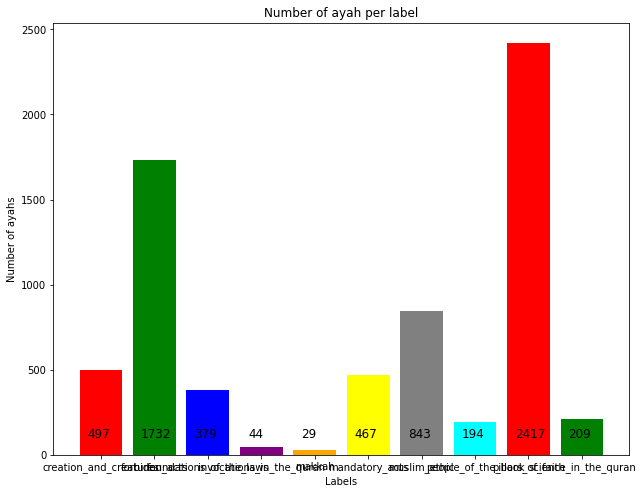

In [81]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
total_count = []
label = y.columns
for lbl in label:
    total_count.append(len(y[y[lbl] == 1]))
ax.bar(label,total_count, color=['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'grey', 'cyan'])
for i,data in enumerate(total_count):
    plt.text(i-.25, 
              data/total_count[i]+100, 
              total_count[i], 
              fontsize=12)
plt.title('Number of ayah per label')
plt.xlabel('Labels')
plt.ylabel('Number of ayahs')

plt.show()

In [82]:
y.sum()

creation_and_creatures       497.0
forbiden_acts               1732.0
foundations_of_the_laws      379.0
invocations_in_the_quran      44.0
makkah                        29.0
mandatory_acts               467.0
muslim_ethic                 843.0
people_of_the_book           194.0
pillars_of_faith            2417.0
science_in_the_quran         209.0
dtype: float64

### Preprocessing

#### Text Cleaning

In [83]:
from nltk.corpus import stopwords
nltk.download('stopwords')

punct = [char for char in string.punctuation]
stop = stopwords.words('english')
def clean_text(txt):
    text = txt.lower()
    for pun in punct:
        text = text.replace(pun, '')

    # remove stopwords
    # text = " ".join([word for word in text.split() if word not in (stop)])

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
df['cleaned_text'] = df['Text'].apply(lambda x: clean_text(x))
df_cleaned = df.drop(['Text', 'Label'], axis=1)
df_cleaned.head()

,Surah,Ayah,cleaned_text
0,1,2,praise be to allah the cherisher and sustainer...
1,1,3,most gracious most merciful
2,1,4,master of the day of judgment
3,1,6,show us the straight way
4,1,7,the way of those on whom thou hast bestowed th...


In [85]:
nltk.download('punkt')
tokens = [nltk.word_tokenize(text) for text in df['cleaned_text']]
df['tokens'] = tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [86]:
df_cleaned.head()

,Surah,Ayah,cleaned_text
0,1,2,praise be to allah the cherisher and sustainer...
1,1,3,most gracious most merciful
2,1,4,master of the day of judgment
3,1,6,show us the straight way
4,1,7,the way of those on whom thou hast bestowed th...


### Text Preprocessing with Neat Text

In [87]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import neattext as nt
import neattext.functions as nfx

In [89]:
df_cleaned['cleaned_text'].apply(lambda x:nt.TextFrame(x).noise_scan())

0       {'text_noise': 10.0, 'text_length': 60, 'noise...
1       {'text_noise': 7.4074074074074066, 'text_lengt...
2       {'text_noise': 10.344827586206897, 'text_lengt...
3       {'text_noise': 12.5, 'text_length': 24, 'noise...
4       {'text_noise': 12.037037037037036, 'text_lengt...
                              ...                        
4049    {'text_noise': 13.953488372093023, 'text_lengt...
4050    {'text_noise': 8.571428571428571, 'text_length...
4051    {'text_noise': 9.803921568627452, 'text_length...
4052    {'text_noise': 10.714285714285714, 'text_lengt...
4053    {'text_noise': 12.5, 'text_length': 48, 'noise...
Name: cleaned_text, Length: 4054, dtype: object

In [90]:
corpus = df_cleaned['cleaned_text']

In [91]:
tfidf = TfidfVectorizer()

In [92]:
Xfeatures = tfidf.fit_transform(corpus).toarray()

In [93]:
Xfeatures

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
X_train,X_test,y_train,y_test = train_test_split(Xfeatures,y,test_size=0.3,random_state=42)

# Train Model

In [95]:
def pipeline_nb(alpha):
  hamming = []
  for al in alpha:
    nb_cc = ClassifierChain(MultinomialNB(alpha = al))
    nb_br = BinaryRelevance(MultinomialNB(alpha = al))
    nb_lp = LabelPowerset(MultinomialNB(alpha = al))

    nb_cc.fit(X_train, y_train)
    nb_br.fit(X_train, y_train)
    nb_lp.fit(X_train, y_train) 

    pred1 = nb_cc.predict(X_test)
    pred2 = nb_br.predict(X_test)
    pred3 = nb_lp.predict(X_test)

    print('\nalpha = ', str(al))
    print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
    print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
    print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

    hamming.append(hamming_loss(y_test, pred1))   
    hamming.append(hamming_loss(y_test, pred2))   
    hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

In [96]:
def pipeline_knn(n_neighbors):
  hamming = []
  for neigh in n_neighbors:
    knn_cc = ClassifierChain(KNeighborsClassifier(n_neighbors=neigh))
    knn_br = BinaryRelevance(KNeighborsClassifier(n_neighbors=neigh))
    knn_lp = LabelPowerset(KNeighborsClassifier(n_neighbors=neigh))

    knn_cc.fit(X_train, y_train)
    knn_br.fit(X_train, y_train)
    knn_lp.fit(X_train, y_train)

    pred1 = knn_cc.predict(X_test)
    pred2 = knn_br.predict(X_test)
    pred3 = knn_lp.predict(X_test)

    print('\nn_neighbors = ', str(neigh))
    print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
    print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
    print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

    hamming.append(hamming_loss(y_test, pred1))   
    hamming.append(hamming_loss(y_test, pred2))   
    hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

In [97]:
def pipeline_svm(kernel, gamma):
  hamming = []
  for ker in kernel:
    for g in gamma :
      svm_cc = ClassifierChain((SVC(kernel=ker, gamma=g)))
      svm_br = BinaryRelevance((SVC(kernel=ker, gamma=g)))
      svm_lp = LabelPowerset((SVC(kernel=ker, gamma=g)))

      svm_cc.fit(X_train, y_train)
      svm_br.fit(X_train, y_train)
      svm_lp.fit(X_train, y_train)

      pred1 = svm_cc.predict(X_test)
      pred2 = svm_br.predict(X_test)
      pred3 = svm_lp.predict(X_test)

      print('\nkernel = %s, gamma = %s' % (str(ker), str(g)))
      print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
      print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
      print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

      hamming.append(hamming_loss(y_test, pred1))   
      hamming.append(hamming_loss(y_test, pred2))   
      hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

In [98]:
def pipeline_dt(random_state):
  hamming = []
  for ran in random_state:
    dt_cc = ClassifierChain(DecisionTreeClassifier(random_state=ran))
    dt_br = BinaryRelevance(DecisionTreeClassifier(random_state=ran))
    dt_lp = LabelPowerset(DecisionTreeClassifier(random_state=ran))

    dt_cc.fit(X_train, y_train)
    dt_br.fit(X_train, y_train)
    dt_lp.fit(X_train, y_train)

    pred1 = dt_cc.predict(X_test)
    pred2 = dt_br.predict(X_test)
    pred3 = dt_lp.predict(X_test)

    print('\nrandom state = ', str(ran))
    print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
    print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
    print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

    hamming.append(hamming_loss(y_test, pred1))   
    hamming.append(hamming_loss(y_test, pred2))   
    hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

**Naive Bayes**

In [99]:
alpha = [0.1, 1.0, 10, 100]

pipeline_nb(alpha)


alpha =  0.1
hamming loss (Classifier Chain): 0.12218570254724732
hamming loss (Binary Relevance): 0.12226787181594084
hamming loss (Label Powerset): 0.13541495480690222

alpha =  1.0
hamming loss (Classifier Chain): 0.1331963845521775
hamming loss (Binary Relevance): 0.1342645850451931
hamming loss (Label Powerset): 0.14839769926047658

alpha =  10
hamming loss (Classifier Chain): 0.15020542317173377
hamming loss (Binary Relevance): 0.15012325390304027
hamming loss (Label Powerset): 0.15053410024650782

alpha =  100
hamming loss (Classifier Chain): 0.15053410024650782
hamming loss (Binary Relevance): 0.15053410024650782
hamming loss (Label Powerset): 0.15053410024650782

BEST :  0.12218570254724732


**KNN**

In [100]:
n_neighbors = [8, 10, 20, 64]

pipeline_knn(n_neighbors)


n_neighbors =  8
hamming loss (Classifier Chain): 0.13081347576006574
hamming loss (Binary Relevance): 0.12522596548890716
hamming loss (Label Powerset): 0.13410024650780608

n_neighbors =  10
hamming loss (Classifier Chain): 0.12793755135579293
hamming loss (Binary Relevance): 0.12530813475760066
hamming loss (Label Powerset): 0.1314708299096138

n_neighbors =  20
hamming loss (Classifier Chain): 0.1322925225965489
hamming loss (Binary Relevance): 0.1265406737880033
hamming loss (Label Powerset): 0.13163516844700082

n_neighbors =  64
hamming loss (Classifier Chain): 0.13294987674609696
hamming loss (Binary Relevance): 0.13352506162695152
hamming loss (Label Powerset): 0.13935907970419062

BEST :  0.12522596548890716


**SVM**

In [101]:
kernel = ["rbf", "linear"]
gamma = [0.1, "auto", "scale"]

pipeline_svm(kernel, gamma)


kernel = rbf, gamma = 0.1
hamming loss (Classifier Chain): 0.13681183237469186
hamming loss (Binary Relevance): 0.138126540673788
hamming loss (Label Powerset): 0.15020542317173377

kernel = rbf, gamma = auto
hamming loss (Classifier Chain): 0.15053410024650782
hamming loss (Binary Relevance): 0.15053410024650782
hamming loss (Label Powerset): 0.15053410024650782

kernel = rbf, gamma = scale
hamming loss (Classifier Chain): 0.12432210353327855
hamming loss (Binary Relevance): 0.11799506984387839
hamming loss (Label Powerset): 0.13870172555464255

kernel = linear, gamma = 0.1
hamming loss (Classifier Chain): 0.11536565324568611
hamming loss (Binary Relevance): 0.1133114215283484
hamming loss (Label Powerset): 0.12990961380443714

kernel = linear, gamma = auto
hamming loss (Classifier Chain): 0.11536565324568611
hamming loss (Binary Relevance): 0.1133114215283484
hamming loss (Label Powerset): 0.12990961380443714

kernel = linear, gamma = scale
hamming loss (Classifier Chain): 0.1153656

**Decision Tree**

In [102]:
random_state = [0, None]

pipeline_dt(random_state)


random state =  0
hamming loss (Classifier Chain): 0.1437962202136401
hamming loss (Binary Relevance): 0.14165981922760887
hamming loss (Label Powerset): 0.18167625308134758

random state =  None
hamming loss (Classifier Chain): 0.14231717337715694
hamming loss (Binary Relevance): 0.14124897288414134
hamming loss (Label Powerset): 0.1779786359901397

BEST :  0.14124897288414134
